In [ ]:
!cp "/content/drive/MyDrive/AI/텐초(2024.06.23~)/img_align_celeba.zip" "."
!unzip "./img_align_celeba.zip" -d "./GAN/"

In [ ]:
import glob
import matplotlib.pyplot as plt
import os
from PIL import Image

pth_to_imgs = "./GAN/img_align_celeba"
imgs = glob.glob(os.path.join(pth_to_imgs, "*"))

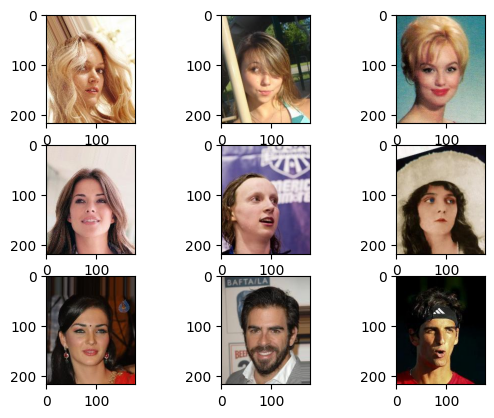

In [ ]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = Image.open(imgs[i])
    plt.imshow(img)
plt.show()

In [ ]:
import torch
import torchvision.transforms as tf
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

transforms = tf.Compose([
    tf.Resize(64),
    tf.CenterCrop(64),
    tf.ToTensor(),
    tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(
    root="./GAN",
    transform=transforms
)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, kernel_size=4),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [ ]:
# GAN 가중치 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
device = "cuda" if  torch.cuda.is_available() else "cpu"

G = Generator().to(device)
G.apply(weights_init)

D = Discriminator().to(device)
D.apply(weights_init)

import tqdm
from torch.optim.adam import Adam

G_optim = Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [ ]:
# 학습 루프 정의
for epoch in range(50):
    iter = tqdm.tqdm(enumerate(loader, 0), total=len(loader))
    for i, data in iter:
        D_optim.zero_grad()

        # 실제 이미지에는 1, 생성 이미지에는 0
        label = torch.ones_like(data[1], dtype=torch.float32).to(device)
        label_fake = torch.zeros_like(data[1], dtype=torch.float32).to(device)

        # 실제 이미지로 감별자 오차 계산
        real = D(data[0].to(device))
        Dloss_real = nn.BCELoss()(torch.squeeze(real), label)
        Dloss_real.backward()

        # 가짜 이미지로 감별자 오차 계산
        noise = torch.randn(label.shape[0], 100, 1, 1, device=device)
        fake = G(noise)
        output = D(fake.detach())
        Dloss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
        Dloss_fake.backward()

        # 감별자 전체 오차 학습
        Dloss = Dloss_real + Dloss_fake
        D_optim.step()

        # 생성자 학습
        G_optim.zero_grad()
        output = D(fake)
        Gloss = nn.BCELoss()(torch.squeeze(output), label)
        Gloss.backward()
        G_optim.step()

        iter.set_description(f"Epoch:{epoch} iteration:{i} D_loss:{Dloss} G_loss:{Gloss}")

torch.save(G.state_dict(), "/content/drive/MyDrive/AI/텐초(2024.06.23~)/Generator.pth")
torch.save(D.state_dict(), "/content/drive/MyDrive/AI/텐초(2024.06.23~)/Discriminatro.pth")

Epoch:0 iteration:30 D_loss:0.21118827164173126 G_loss:6.588454246520996:   2%|▏         | 31/1583 [05:08<4:17:03,  9.94s/it]


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    G.load_state_dict(
        torch.load("/content/drive/MyDrive/AI/텐초(2024.06.23~)/Generator.pth", map_location=device)
    )

    feature_vector = torch.randn(1, 100, 1, 1).to(device)
    pred = G(feature_vector).squeeze()
    pred = pred.permute(1,2,0).cpu().numpy()

    plt.imshow(pred)
    plt.title("predicted image")
    plt.show()